In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [119]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

In [9]:
# Get the columns names from the Measurement table for reference
session.query(Measurement).statement.columns.keys()

/Users/fsantosvix/anaconda3/envs/myfirstpythonenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SADeprecationWarning: The SelectBase.c and SelectBase.columns attributes are deprecated and will be removed in a future release; these attributes implicitly create a subquery that should be explicit.  Please call SelectBase.subquery() first in order to create a subquery, which then contains this attribute.  To access the columns that this SELECT object SELECTs from, use the SelectBase.selected_columns attribute. (deprecated since: 1.4)
  """Entry point for launching an IPython kernel.


['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
# Get the columns names from the Station table for reference
session.query(Station).statement.columns.keys()

/Users/fsantosvix/anaconda3/envs/myfirstpythonenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SADeprecationWarning: The SelectBase.c and SelectBase.columns attributes are deprecated and will be removed in a future release; these attributes implicitly create a subquery that should be explicit.  Please call SelectBase.subquery() first in order to create a subquery, which then contains this attribute.  To access the columns that this SELECT object SELECTs from, use the SelectBase.selected_columns attribute. (deprecated since: 1.4)
  """Entry point for launching an IPython kernel.


['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
query_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = query_date[0]
latest_date

'2017-08-23'

In [204]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Convert latest date to permit calculations
converted_date = datetime.strptime(latest_date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
start_date = converted_date - dt.timedelta(days=365)
# Convert the start date back to be used in the queries
str_start_date = start_date.strftime('%Y-%m-%d')
# Display the start date
str_start_date


'2016-08-23'

In [157]:
# Perform a query to retrieve the data and precipitation scores from the start date
prcp_query = session.query(Measurement.date,
               Measurement.prcp)\
               .filter(Measurement.date >= str_start_date).all()

In [158]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_query, columns=['Date', 'Precipitation'])
# Display the dataframe
prcp_df

,Date,Precipitation
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0
...,...,...
2225,2017-08-19,2.3
2226,2017-08-20,NaN
2227,2017-08-21,14.2
2228,2017-08-22,12.7


In [166]:
# Sort the dataframe by date
sorted_prcp_df = prcp_df.sort_values('Date')
sorted_prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.0
1009,2016-08-23,NaN
1529,2016-08-23,45.5
704,2016-08-23,1.3
361,2016-08-23,3.8


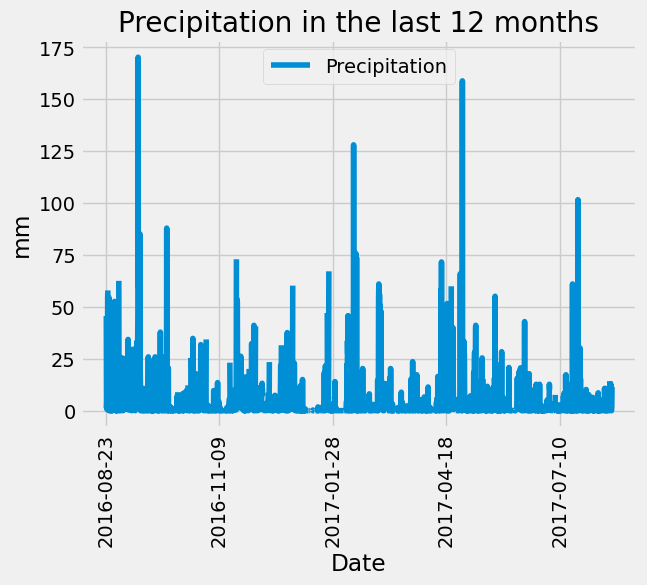

In [207]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp_df.plot(x='Date', y='Precipitation',rot=90)
plt.ylabel('mm')
plt.title('Precipitation in the last 12 months')

# plt.tight_layout()
plt.show()

In [171]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_df.describe()
# Dislpay the summary statistics
summary_statistics

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [173]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Measurement.station).distinct().count()
# Display the number of different stations
number_of_stations

9

In [135]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,
              func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()
# Display the list of stations and counts
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [138]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_details = session.query(Measurement.station,
              func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))\
              .filter(Measurement.station == most_active_stations[0][0]).all()
most_active_details

[('USC00519281', 12.2, 29.4, 22.03582251082252)]

In [141]:
# Find the latest date for the most active station
query_date_most_active = session.query(Measurement.date)\
    .filter(Measurement.station == most_active_stations[0][0])\
    .order_by(Measurement.date.desc())\
    .first()
latest_date_most_active = query_date_most_active[0]
latest_date_most_active

'2017-08-18'

In [177]:
# Calculate 12 months before the latest date for the most active station

# Convert latest date for calculations
converted_date_most_active = datetime.strptime(latest_date_most_active, '%Y-%m-%d').date()
# Calculate the date 365 days before
start_date_most_active = converted_date_most_active - dt.timedelta(days=365)
# Convert back for queries
str_start_date_most_active = start_date_most_active.strftime('%Y-%m-%d')
str_start_date_most_active

'2016-08-18'

In [178]:
# Perform a query to retrieve the date and temperature scores for the most active station in the last 12 months of data
tobs_query = session.query(Measurement.date,
                        Measurement.tobs)\
                        .filter((Measurement.station == most_active_stations[0][0])
                       & (Measurement.date >= str_start_date_most_active)).all()

In [210]:
# Convert query results into a dataframe
tobs_df = pd.DataFrame(tobs_query, columns=['Date','Temp. Observed'])
tobs_df

,Date,Temp. Observed
0,2016-08-18,26.7
1,2016-08-19,26.1
2,2016-08-20,27.2
3,2016-08-21,26.1
4,2016-08-22,25.6
...,...,...
352,2017-08-14,25.0
353,2017-08-15,25.0
354,2017-08-16,24.4
355,2017-08-17,24.4


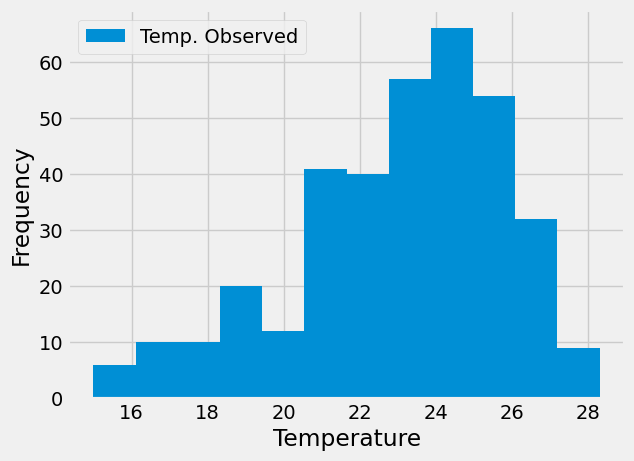

In [211]:
# Plot the results in a histogram chart
tobs_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.show()

Text(0.5, 4.183333333333314, 'Temperature')

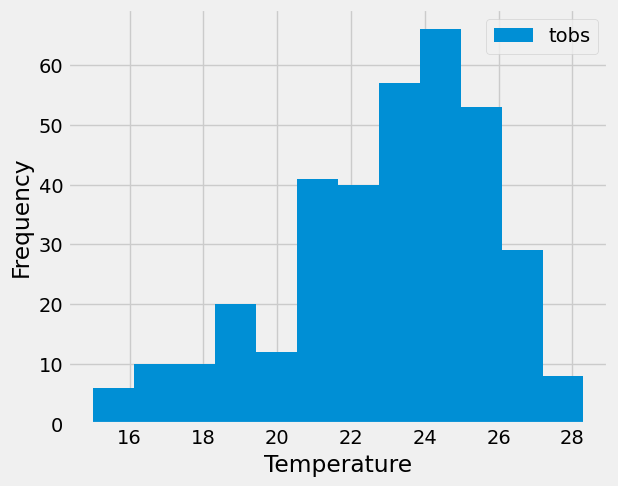

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [212]:
# Close Session
session.close()
